<a href="https://colab.research.google.com/github/MightyManjaly/Datascience_Project/blob/main/Final_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import zipfile
import os

# Define the path to the ZIP file
zip_file_path = '/content/drive/MyDrive/processed_images.zip'

# Define the directory to extract to
extract_dir = '/New_Processed'

# Create the directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Files unzipped to {extract_dir}")


Files unzipped to /New_Processed


In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split



# Step 2: List processed images and save to CSV
processed_dir = '/New_Processed/processed_images'

# List all processed image files
processed_filepaths = []
for filename in os.listdir(processed_dir):
    if filename.endswith('.jpeg'):
        processed_filepaths.append(os.path.join(processed_dir, filename))

# Create a DataFrame with the file paths
df = pd.DataFrame({
    'processed_filepaths': processed_filepaths
})

# Save the DataFrame to a CSV file
processed_df_path = '/New_Processed/processed_image_data.csv'
df.to_csv(processed_df_path, index=False)

print("Processed image paths saved to CSV.")

# Step 3: Load the CSV file containing processed image paths
df = pd.read_csv(processed_df_path)

# Load the CSV file with labels
csv_file_path = '/content/drive/MyDrive/trainLabels.csv'
labels_df = pd.read_csv(csv_file_path)

# Display the first few rows of the CSV to understand its structure
print("CSV File Preview:")
print(labels_df.head())

# Step 4: Merge with labels
# Assuming 'image' and 'level' are the columns in the CSV
labels_df['image'] = labels_df['image'].apply(lambda x: x + '.jpeg')  # Append .jpeg to the image names if not already present

# Extract image names from file paths in df
df['image'] = df['processed_filepaths'].apply(lambda x: os.path.basename(x))

# Merge the CSV data with the processed file paths
merged_df = df.merge(labels_df, left_on='image', right_on='image')

# Step 5: Split data into training and testing sets
train_df, test_df = train_test_split(merged_df, test_size=0.2, stratify=merged_df['level'], random_state=42)

# Print the number of images in each class for both the training and testing sets
print("Training set class distribution:")
print(train_df['level'].value_counts())

print("Testing set class distribution:")
print(test_df['level'].value_counts())

# Step 6: Save the training and testing DataFrames for future use
train_df.to_csv('/train_data.csv', index=False)
test_df.to_csv('/test_data.csv', index=False)

# Optionally, display the DataFrame to verify the results
#import ace_tools as tools; tools.display_dataframe_to_user(name="Train DataFrame", dataframe=train_df)
#tools.display_dataframe_to_user(name="Test DataFrame", dataframe=test_df)


Processed image paths saved to CSV.
CSV File Preview:
      image  level
0   10_left      0
1  10_right      0
2   13_left      0
3  13_right      0
4   15_left      1
Training set class distribution:
level
0    20648
2     4234
1     1954
3      698
4      566
Name: count, dtype: int64
Testing set class distribution:
level
0    5162
2    1058
1     489
3     175
4     142
Name: count, dtype: int64


In [ ]:

from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
import pandas as pd
# Step 6: Oversample the training data to balance the classes
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(train_df[['processed_filepaths']], train_df['level'])

# Create a new DataFrame with the oversampled data
train_df_resampled = pd.DataFrame({
    'processed_filepaths': X_resampled['processed_filepaths'],
    'level': y_resampled
})

# Convert the 'level' column to string type
train_df_resampled['level'] = train_df_resampled['level'].astype(str)
test_df['level'] = test_df['level'].astype(str)

# Save the training and testing DataFrames for future use
train_df_resampled.to_csv('/train_data_resampled.csv', index=False)
test_df.to_csv('/test_data.csv', index=False)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Convert the 'level' column to string type
train_df_resampled['level'] = train_df_resampled['level'].astype(str)
test_df['level'] = test_df['level'].astype(str)

# Create image data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Create training generator
train_generator = train_datagen.flow_from_dataframe(
    train_df_resampled,
    x_col='processed_filepaths',
    y_col='level',
    target_size=(299, 299),
    batch_size=64,
    class_mode='categorical'
)

# Create validation generator
val_generator = val_datagen.flow_from_dataframe(
    test_df,
    x_col='processed_filepaths',
    y_col='level',
    target_size=(299, 299),
    batch_size=64,
    class_mode='categorical'
)


Found 103240 validated image filenames belonging to 5 classes.
Found 7026 validated image filenames belonging to 5 classes.


In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Warnings
import warnings
warnings.filterwarnings('ignore')
# -----------------4. Set Up Data Generators----------------#

# Split the DataFrame into training and validation sets
#train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Check the distribution of labels in train and val sets
#print("Train set label distribution:\n", train_df['labels'].value_counts())
#print("Validation set label distribution:\n", val_df['labels'].value_counts())

# Convert the 'level' column to string type
train_df['level'] = train_df['level'].astype(str)
test_df['level'] = test_df['level'].astype(str)

# Define image data generators with increased data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='processed_filepaths',
    y_col='level',
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    test_df,
    x_col='processed_filepaths',
    y_col='level',
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

Found 28100 validated image filenames belonging to 5 classes.
Found 7026 validated image filenames belonging to 5 classes.


In [ ]:
# ----------------5. Build and Compile Model------------------------#

from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Load the InceptionV3 model with pre-trained ImageNet weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with a smaller learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# --------------------6. Train the Model------------------------#

from tensorflow.keras.callbacks import EarlyStopping

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size,
    epochs=15,  # Increase number of epochs
    callbacks=[early_stopping]
)

Epoch 1/15


In [ ]:
model_save_path = '/content/drive/MyDrive/Final_Cardio_Vas.h5'
model.save(model_save_path)

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(val_generator, steps=val_generator.n // val_generator.batch_size)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

219/219 [==============================] - 45s 204ms/step - loss: 0.6334 - accuracy: 0.8021
Test Loss: 0.6334405541419983
Test Accuracy: 0.8020833134651184


In [ ]:
model_save_path = '/content/drive/MyDrive/Cardio_Vas.h5'
model.save(model_save_path)

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(val_generator, steps=val_generator.n // val_generator.batch_size)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

219/219 [==============================] - 42s 192ms/step - loss: 0.6346 - accuracy: 0.8074
Test Loss: 0.6346424221992493
Test Accuracy: 0.8073630332946777


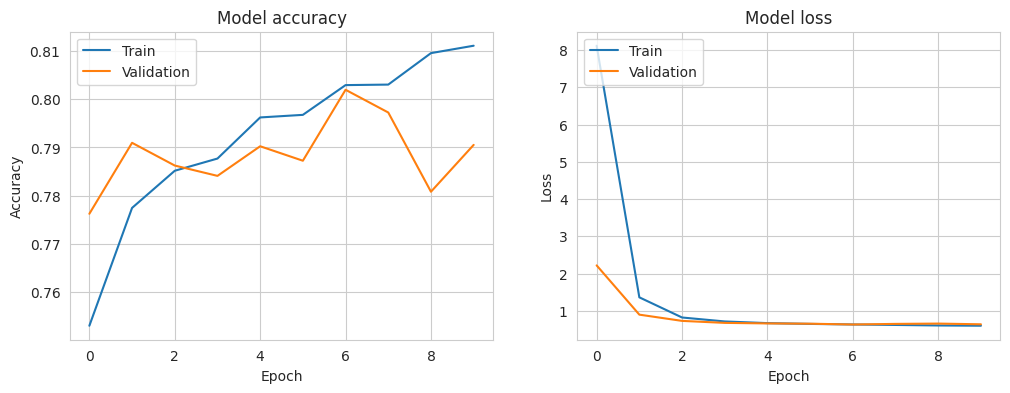

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [ ]:
# Load the saved model
model_save_path = '/content/drive/MyDrive/Final_Cardio_Vas.h5'
model = load_model(model_save_path)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights_dict = dict(enumerate(class_weights))
print("Class Weights: ", class_weights_dict)


Class Weights:  {0: 0.2721813250678032, 1: 2.8761514841351077, 2: 1.3273500236183278, 3: 8.051575931232092, 4: 9.929328621908127}


In [ ]:
from tensorflow.keras.optimizers import Adam

# Unfreeze the last few layers of the base model for fine-tuning
for layer in model.layers[-20:]:
    layer.trainable = True

# Compile the model with a smaller learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Verify the model structure
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_282 (Conv2D)         (None, 149, 149, 32)         864       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_282 (B  (None, 149, 149, 32)         96        ['conv2d_282[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_282 (Activation  (None, 149, 149, 32)         0         ['batch_normalization_28

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights_dict = dict(enumerate(class_weights))
print("Class Weights: ", class_weights_dict)


Class Weights:  {0: 0.2721813250678032, 1: 2.8761514841351077, 2: 1.3273500236183278, 3: 8.051575931232092, 4: 9.929328621908127}


In [ ]:
# Example of initial class weights
initial_class_weights = {0: 0.272, 1: 2.876, 2: 1.327, 3: 8.052, 4: 9.929}

# Manually adjust weights to avoid extreme values
adjusted_class_weights = {0: 0.5, 1: 3, 2: 1.5, 3: 7, 4: 9}

In [ ]:
from tensorflow.keras.models import load_model

# Load the model saved before fine-tuning
model = load_model('/content/drive/MyDrive/Cardio_Vas.h5')


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define the adjusted class weights
adjusted_class_weights = {0: 0.5, 1: 3, 2: 1.5, 3: 7, 4: 9}

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
#model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/best_model_no_finetuning.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Assuming train_generator and val_generator are already defined
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size,
    epochs=10,
    callbacks=[early_stopping, lr_scheduler],
    class_weight=adjusted_class_weights  # Apply adjusted class weights here
)


Epoch 1/10
878/878 [==============================] - 754s 853ms/step - loss: 1.1867 - accuracy: 0.7602 - val_loss: 0.8943 - val_accuracy: 0.7160 - lr: 1.0000e-04
Epoch 2/10
878/878 [==============================] - 747s 851ms/step - loss: 1.1771 - accuracy: 0.7529 - val_loss: 1.0431 - val_accuracy: 0.5021 - lr: 1.0000e-04
Epoch 3/10
878/878 [==============================] - ETA: 0s - loss: 1.1698 - accuracy: 0.7496
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
878/878 [==============================] - 750s 854ms/step - loss: 1.1698 - accuracy: 0.7496 - val_loss: 0.9377 - val_accuracy: 0.6714 - lr: 1.0000e-04
Epoch 4/10
878/878 [==============================] - 738s 841ms/step - loss: 1.1567 - accuracy: 0.7521 - val_loss: 0.8411 - val_accuracy: 0.7280 - lr: 5.0000e-05
Epoch 5/10
878/878 [==============================] - 740s 843ms/step - loss: 1.1520 - accuracy: 0.7512 - val_loss: 0.9300 - val_accuracy: 0.6767 - lr: 5.0000e-05
Epoch 6/10
878/878 [====

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(val_generator, steps=val_generator.n // val_generator.batch_size)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

219/219 [==============================] - 43s 197ms/step - loss: 0.8409 - accuracy: 0.7280
Test Loss: 0.8409423828125
Test Accuracy: 0.7280251383781433


In [ ]:
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Predict on the test data
y_pred_prob = model.predict(val_generator, steps=val_generator.n // val_generator.batch_size)
y_pred = np.argmax(y_pred_prob, axis=1)  # Use argmax for multi-class classification

# Ensure the number of predictions matches the number of true labels
y_test = val_generator.classes[:len(y_pred)]

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate F1 score, precision, and recall
f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print("Confusion Matrix:\n", conf_matrix)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)


219/219 [==============================] - 47s 209ms/step
Confusion Matrix:
 [[3581  447  741  233  147]
 [ 329   42   83   23   10]
 [ 713  104  170   39   29]
 [ 125   18   23    6    3]
 [ 103    8   23    5    3]]
F1 Score: 0.5569114052671993
Precision: 0.5725069578531188
Recall: 0.5425228310502284


In [ ]:
# Load the saved model
model_save_path = '/content/drive/MyDrive/Cardio_Vas.h5'
model = load_model(model_save_path)

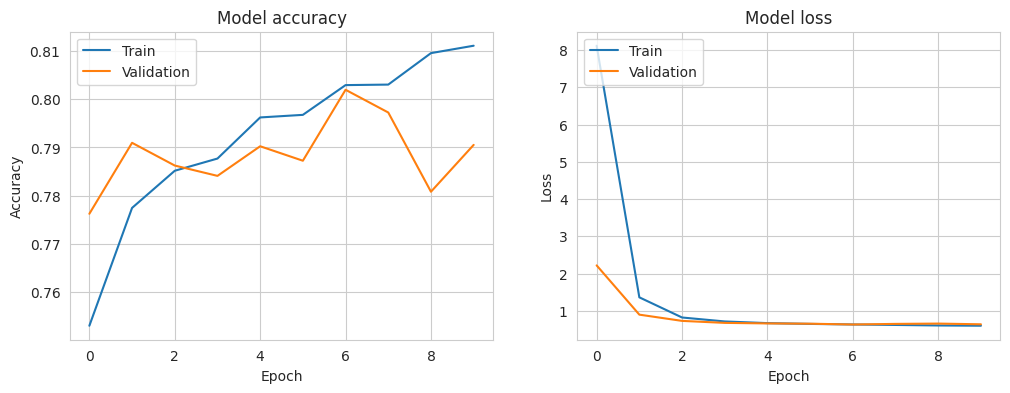

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()



1/1 [==============================] - 1s 1s/step
Predicted class: No CVD


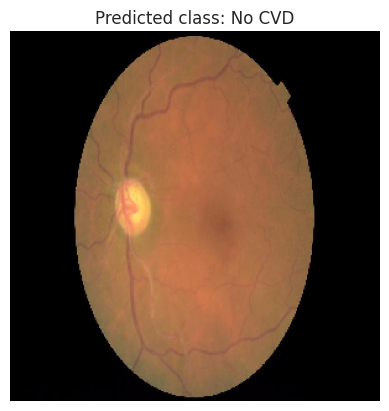

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the trained model (assuming you have already saved the model)
model = load_model('/content/drive/MyDrive/Final_Cardio_Vas.h5')

# Load and preprocess the image
img_path = '/15_left.jpeg'
img = image.load_img(img_path, target_size=(299, 299))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Make a prediction
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]

# Class mapping
class_mapping = {0: 'No CVD', 1: 'Low Risk', 2: 'Moderate Risk', 3: 'High Risk', 4: 'Very High Risk'}

# Get the predicted class label
predicted_class_label = class_mapping[predicted_class]

# Print the predicted class label
print(f'Predicted class: {predicted_class_label}')

# Plot the image with the prediction
plt.imshow(img)
plt.title(f'Predicted class: {predicted_class_label}')
plt.axis('off')
plt.show()


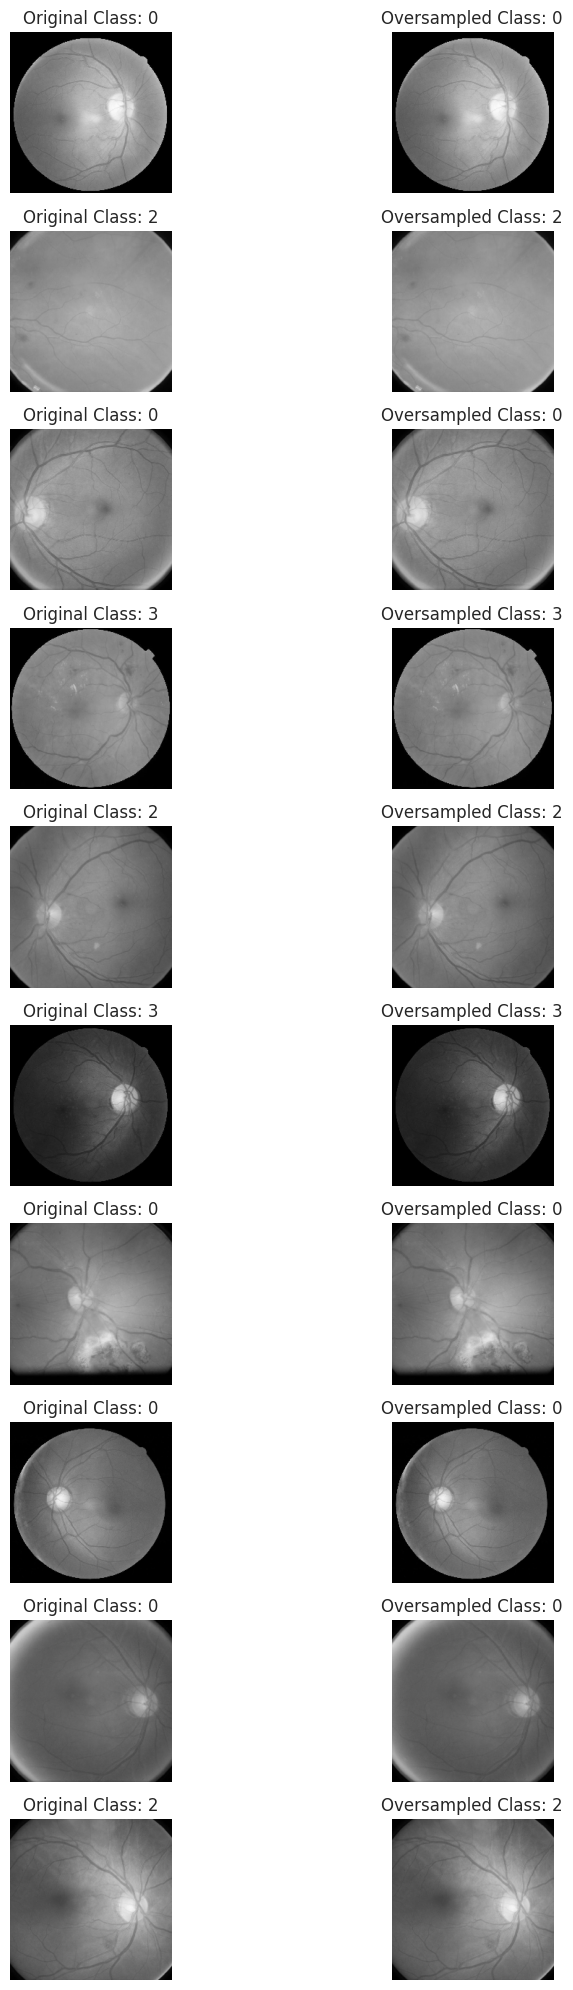

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

def display_oversampled_samples(generator, num_samples=10):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 2))

    for i in range(num_samples):
        # Original image
        original_img_path = generator.image_paths[i]
        original_img = load_img(original_img_path, target_size=(224, 224))
        axes[i, 0].imshow(original_img)
        axes[i, 0].set_title(f"Original Class: {np.argmax(generator.y[i])}")
        axes[i, 0].axis('off')

        # Oversampled image
        oversampled_img_path = generator.oversampled_image_paths[i]
        oversampled_img = load_img(oversampled_img_path, target_size=(224, 224))
        axes[i, 1].imshow(oversampled_img)
        axes[i, 1].set_title(f"Oversampled Class: {np.argmax(generator.oversampled_y[i])}")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Create an instance of the data generator with image paths
batch_size = 32
train_generator = BalancedDataGenerator(X_train, y_train, train_df['processed_filepaths'].values, batch_size=batch_size)

# Display oversampled samples
display_oversampled_samples(train_generator, num_samples=10)


In [ ]:
from tensorflow.keras.models import load_model
model_path = '/content/drive/MyDrive/Cardio_Vas.h5'
model = load_model(model_path)

Found 7026 validated image filenames belonging to 5 classes.
110/110 [==============================] - 63s 571ms/step


<ipython-input-15-d567d13dfde5>:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10').colors  # Use a colormap with enough distinct colors


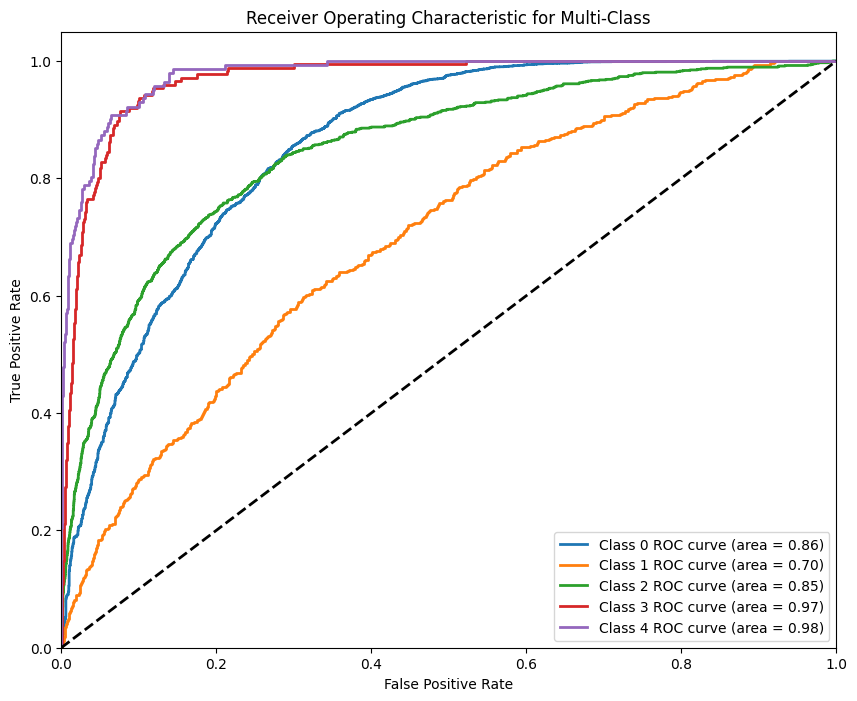

In [ ]:
#ROC Curve

import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from google.colab import drive


# Step 3: Load the test data
test_data_path = '/test_data.csv'  # Adjust the path as needed
test_df = pd.read_csv(test_data_path)

# Convert the 'level' column to string type
test_df['level'] = test_df['level'].astype(str)

# Step 4: Create the ImageDataGenerator for validation data
val_datagen = ImageDataGenerator(rescale=1./255)

# Create validation generator
val_generator = val_datagen.flow_from_dataframe(
    test_df,
    x_col='processed_filepaths',
    y_col='level',
    target_size=(299, 299),
    batch_size=64,
    class_mode='categorical',
    shuffle=False  # Important to keep data order for correct predictions
)

# Step 5: Make predictions on the validation data
y_pred_prob = model.predict(val_generator, steps=val_generator.n // val_generator.batch_size + 1, verbose=1)

# Ensure y_test is a numpy array of true labels
y_test = np.array(val_generator.classes[:len(y_pred_prob)])

# Step 6: Compute ROC curve and ROC area for each class
n_classes = len(val_generator.class_indices)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 7: Plot all ROC curves
plt.figure(figsize=(10, 8))

colors = plt.cm.get_cmap('tab10').colors  # Use a colormap with enough distinct colors
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} ROC curve (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc="lower right")
plt.show()


Found 7026 validated image filenames belonging to 5 classes.
110/110 [==============================] - 61s 555ms/step


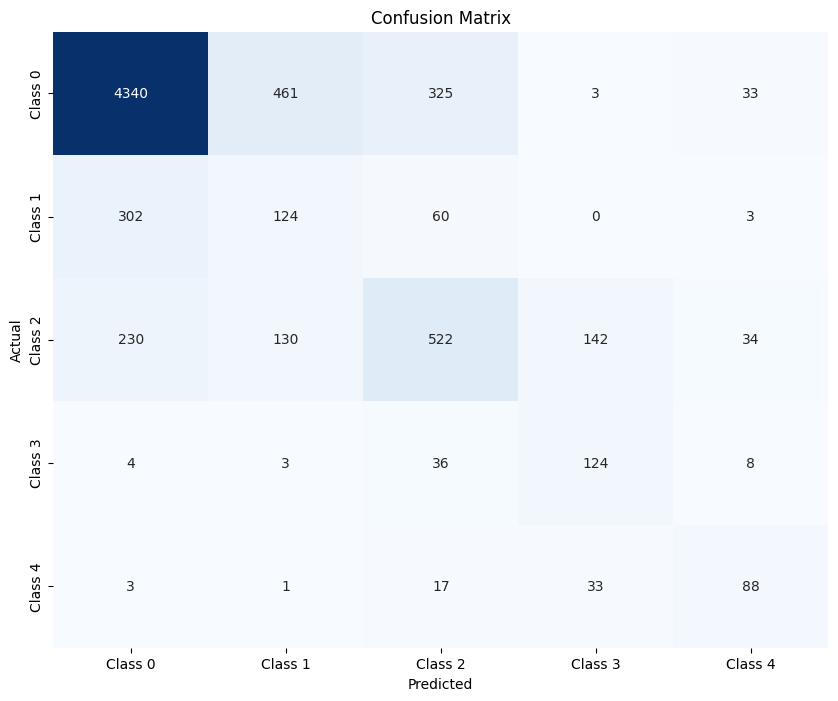

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive



# Step 3: Load the test data
test_data_path = '/test_data.csv'  # Adjust the path as needed
test_df = pd.read_csv(test_data_path)

# Convert the 'level' column to string type
test_df['level'] = test_df['level'].astype(str)

# Step 4: Create the ImageDataGenerator for validation data
val_datagen = ImageDataGenerator(rescale=1./255)

# Create validation generator
val_generator = val_datagen.flow_from_dataframe(
    test_df,
    x_col='processed_filepaths',
    y_col='level',
    target_size=(299, 299),
    batch_size=64,
    class_mode='categorical',
    shuffle=False  # Important to keep data order for correct predictions
)

# Step 5: Make predictions on the validation data
y_pred_prob = model.predict(val_generator, steps=val_generator.n // val_generator.batch_size + 1, verbose=1)
y_pred = np.argmax(y_pred_prob, axis=1)

# Ensure y_test is a numpy array of true labels
y_test = np.array(val_generator.classes[:len(y_pred)])

# Step 6: Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=[f"Class {i}" for i in range(len(val_generator.class_indices))], columns=[f"Class {i}" for i in range(len(val_generator.class_indices))])

# Step 7: Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
# Step 8: Print precision, recall, F1-score, and other metrics
report = classification_report(y_test, y_pred, target_names=[f"Class {i}" for i in range(len(val_generator.class_indices))])
print(report)

              precision    recall  f1-score   support

     Class 0       0.89      0.84      0.86      5162
     Class 1       0.17      0.25      0.21       489
     Class 2       0.54      0.49      0.52      1058
     Class 3       0.41      0.71      0.52       175
     Class 4       0.53      0.62      0.57       142

    accuracy                           0.74      7026
   macro avg       0.51      0.58      0.54      7026
weighted avg       0.77      0.74      0.75      7026



Found 7026 validated image filenames belonging to 5 classes.
Found 1 validated image filenames belonging to 1 classes.
1/1 [==============================] - 2s 2s/step
Predicted class: Very High Risk


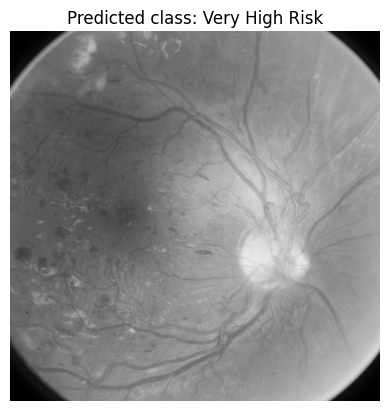

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive



# Step 3: Load the test data
test_data_path = '/test_data.csv'  # Adjust the path as needed
test_df = pd.read_csv(test_data_path)

# Convert the 'level' column to string type
test_df['level'] = test_df['level'].astype(str)

# Step 4: Create the ImageDataGenerator for validation data
val_datagen = ImageDataGenerator(rescale=1./255)

# Create validation generator
val_generator = val_datagen.flow_from_dataframe(
    test_df,
    x_col='processed_filepaths',
    y_col='level',
    target_size=(299, 299),
    batch_size=64,
    class_mode='categorical',
    shuffle=False  # Important to keep data order for correct predictions
)

# Path to the single image you want to predict
img_path = '/16_left.jpeg'

# Step 5: Create a single image generator
single_image_df = pd.DataFrame({'processed_filepaths': [img_path], 'level': ['0']})  # Dummy label
single_image_generator = val_datagen.flow_from_dataframe(
    single_image_df,
    x_col='processed_filepaths',
    y_col='level',
    target_size=(299, 299),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

# Step 6: Make the prediction
predictions = model.predict(single_image_generator)
predicted_class = np.argmax(predictions, axis=1)[0]

# Step 7: Map the predicted class to the class label
class_mapping = {
    0: 'No CVD',
    1: 'Low Risk',
    2: 'Moderate Risk',
    3: 'High Risk',
    4: 'Very High Risk'
}

predicted_class_label = class_mapping[predicted_class]

# Print the predicted class label
print(f'Predicted class: {predicted_class_label}')

# Step 8: Plot the image with the prediction
plt.imshow(image.load_img(img_path))
plt.title(f'Predicted class: {predicted_class_label}')
plt.axis('off')
plt.show()


Found 7026 validated image filenames belonging to 5 classes.
Found 1 validated image filenames belonging to 1 classes.
1/1 [==============================] - 0s 62ms/step
Predicted class: No CVD


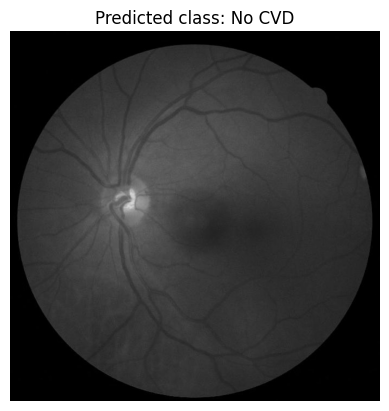

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive



# Step 3: Load the test data
test_data_path = '/test_data.csv'  # Adjust the path as needed
test_df = pd.read_csv(test_data_path)

# Convert the 'level' column to string type
test_df['level'] = test_df['level'].astype(str)

# Step 4: Create the ImageDataGenerator for validation data
val_datagen = ImageDataGenerator(rescale=1./255)

# Create validation generator
val_generator = val_datagen.flow_from_dataframe(
    test_df,
    x_col='processed_filepaths',
    y_col='level',
    target_size=(299, 299),
    batch_size=64,
    class_mode='categorical',
    shuffle=False  # Important to keep data order for correct predictions
)

# Path to the single image you want to predict
img_path = '/19_left.jpeg'

# Step 5: Create a single image generator
single_image_df = pd.DataFrame({'processed_filepaths': [img_path], 'level': ['0']})  # Dummy label
single_image_generator = val_datagen.flow_from_dataframe(
    single_image_df,
    x_col='processed_filepaths',
    y_col='level',
    target_size=(299, 299),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

# Step 6: Make the prediction
predictions = model.predict(single_image_generator)
predicted_class = np.argmax(predictions, axis=1)[0]

# Step 7: Map the predicted class to the class label
class_mapping = {
    0: 'No CVD',
    1: 'Low Risk',
    2: 'Moderate Risk',
    3: 'High Risk',
    4: 'Very High Risk'
}

predicted_class_label = class_mapping[predicted_class]

# Print the predicted class label
print(f'Predicted class: {predicted_class_label}')

# Step 8: Plot the image with the prediction
plt.imshow(image.load_img(img_path))
plt.title(f'Predicted class: {predicted_class_label}')
plt.axis('off')
plt.show()


Found 7026 validated image filenames belonging to 5 classes.
Found 1 validated image filenames belonging to 1 classes.
1/1 [==============================] - 0s 69ms/step
Predicted class: Moderate Risk


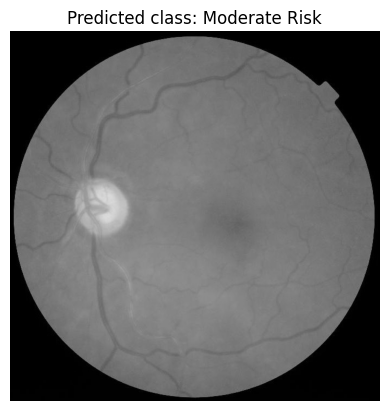

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive



# Step 3: Load the test data
test_data_path = '/test_data.csv'  # Adjust the path as needed
test_df = pd.read_csv(test_data_path)

# Convert the 'level' column to string type
test_df['level'] = test_df['level'].astype(str)

# Step 4: Create the ImageDataGenerator for validation data
val_datagen = ImageDataGenerator(rescale=1./255)

# Create validation generator
val_generator = val_datagen.flow_from_dataframe(
    test_df,
    x_col='processed_filepaths',
    y_col='level',
    target_size=(299, 299),
    batch_size=64,
    class_mode='categorical',
    shuffle=False  # Important to keep data order for correct predictions
)

# Path to the single image you want to predict
img_path = '/15_left.jpeg'

# Step 5: Create a single image generator
single_image_df = pd.DataFrame({'processed_filepaths': [img_path], 'level': ['0']})  # Dummy label
single_image_generator = val_datagen.flow_from_dataframe(
    single_image_df,
    x_col='processed_filepaths',
    y_col='level',
    target_size=(299, 299),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

# Step 6: Make the prediction
predictions = model.predict(single_image_generator)
predicted_class = np.argmax(predictions, axis=1)[0]

# Step 7: Map the predicted class to the class label
class_mapping = {
    0: 'No CVD',
    1: 'Low Risk',
    2: 'Moderate Risk',
    3: 'High Risk',
    4: 'Very High Risk'
}

predicted_class_label = class_mapping[predicted_class]

# Print the predicted class label
print(f'Predicted class: {predicted_class_label}')

# Step 8: Plot the image with the prediction
plt.imshow(image.load_img(img_path))
plt.title(f'Predicted class: {predicted_class_label}')
plt.axis('off')
plt.show()


Found 7026 validated image filenames belonging to 5 classes.
Found 1 validated image filenames belonging to 1 classes.
1/1 [==============================] - 0s 44ms/step
Predicted class: Moderate Risk


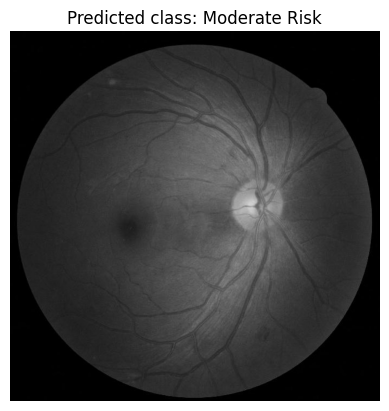

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive



# Step 3: Load the test data
test_data_path = '/test_data.csv'  # Adjust the path as needed
test_df = pd.read_csv(test_data_path)

# Convert the 'level' column to string type
test_df['level'] = test_df['level'].astype(str)

# Step 4: Create the ImageDataGenerator for validation data
val_datagen = ImageDataGenerator(rescale=1./255)

# Create validation generator
val_generator = val_datagen.flow_from_dataframe(
    test_df,
    x_col='processed_filepaths',
    y_col='level',
    target_size=(299, 299),
    batch_size=64,
    class_mode='categorical',
    shuffle=False  # Important to keep data order for correct predictions
)

# Path to the single image you want to predict
img_path = '/352_right.jpeg'

# Step 5: Create a single image generator
single_image_df = pd.DataFrame({'processed_filepaths': [img_path], 'level': ['0']})  # Dummy label
single_image_generator = val_datagen.flow_from_dataframe(
    single_image_df,
    x_col='processed_filepaths',
    y_col='level',
    target_size=(299, 299),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

# Step 6: Make the prediction
predictions = model.predict(single_image_generator)
predicted_class = np.argmax(predictions, axis=1)[0]

# Step 7: Map the predicted class to the class label
class_mapping = {
    0: 'No CVD',
    1: 'Low Risk',
    2: 'Moderate Risk',
    3: 'High Risk',
    4: 'Very High Risk'
}

predicted_class_label = class_mapping[predicted_class]

# Print the predicted class label
print(f'Predicted class: {predicted_class_label}')

# Step 8: Plot the image with the prediction
plt.imshow(image.load_img(img_path))
plt.title(f'Predicted class: {predicted_class_label}')
plt.axis('off')
plt.show()
